This weather timeseries dataset recorded at the weather station at the Max planck Institute for Biogeochemistry in jena,Germany.
In this dataset, 14 different quantities (such as air temperature, atmospheric pressure,humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009-2016. we'll use it to buld a model that takes aas input some data from the recent past (a few days worth of data points) and predicts the air temperature  24 hours in the future.

**Inspecting the data of the Jena weather dataset**

In [1]:
import os 

data_dir = r"C:\Users\Raju\Downloads\jena_climate"
fname = os.path.join(data_dir , 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


**Now, converting all 420,551 lines of data into a Numpy array**

In [2]:
import numpy as np 
float_data = np.zeros((len(lines) , len(header) - 1))

for i , line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,: ] = values

**Plotting the temperature timeseries**

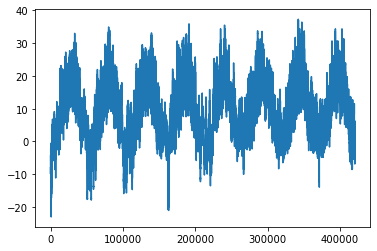

In [3]:
from matplotlib import pyplot as plt 

temp = float_data[ : , 1]
plt.plot(range(len(temp)) , temp )
plt.show()

**plotting the first 10 days of the temperature timeseries:-**

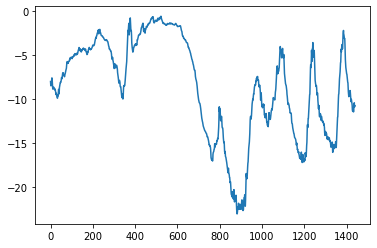

In [4]:
plt.plot(range(1440) , temp[:1440])
plt.show()

**Normalizing the Data**

We'll preprocess the data by subtracting the mean of each timesteps and dividing by the standard deviation.

In [5]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[: 200000].std(axis = 0)
float_data /= std

Now, let’s use the abstract generator function to instantiate three generators: 
- one for training, one for validation, and one for testing.

Each will look at different temporal segments of the original data: 
- The training generator looks at the first 200,000 timesteps, 
- The validation generator looks at the following 100,000, and 
- The test generator looks at the remainder

In [34]:
 def Generator(data, lookback , delay , min_index , max_index , shuffle = False , batch_size = 128 , step = 6 ):
        import numpy as np

        if max_index is None:
            max_index = len(data) - delay -1

        i = min_index + lookback

        while 1 :
            if shuffle:
                rows = np.random.randint(min_index + lookback , max_index , size = batch_size)

            else :
                if i + batch_size >= max_index:
                    i = min_index + lookback

                rows = np.arange( i , min(i + batch_size , max_index))

                i += len(rows)

            samples = np.zeros((len(rows) , lookback // step , data.shape[-1]))
            targets = np.zeros((len(rows), ))

            for j , rows in enumerate(rows):
                indices = range(rows[j] - lookback , rows[j] , step)

                samples[j] = data[indices]
                targets[j] = data[rows[j] + delay][1]

        yield samples , targets




In [36]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = Generator( float_data,
                        lookback = lookback,
                        delay = delay,
                        min_index = 0,
                        max_index = 200000,
                        shuffle = True,
                        step = step,
                        batch_size = batch_size)

val_gen = Generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index =200001,
                    max_index = 300000,
                    step = step,
                    batch_size= batch_size)

test_gen = Generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 300001,
                    max_index = None,
                    step= step,
                    batch_size= batch_size)

In [39]:
val_steps = (300000 - 200001 - lookback)
# How many steps to draw from val_gen in order to see the entire validation set

test_steps = (len(float_data) -300001 - lookback) 
# How many steps to draw from test_gen in order to see the entire test set

**Training and Evaluating a Densely connected model**

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model  = Sequential()
model.add(layers.Flatten(input_shape = (lookback// step , float_data.shape[-1])))
model.add(layers.Dense(32,  activation= 'relu'))
model.add(layers.Dense(1))

model.compile(optimizer= RMSprop(), loss= 'mae')

history = model.fit_generator(train_gen,
                                steps_per_epoch= 500,
                                epochs= 20 ,
                                validation_data= val_gen,
                                validation_steps= val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.


IndexError: invalid index to scalar variable.